<h1> Abstract <h1>

<h5> In this post I hope to explore the penguin data set and find a combination of variables that will give us the highest accurate rate when trying to predict the species of a penguin. I will start by cleaning up the data and exploring a few visual representation in order to gain insight into some of the most notable variables for species prediction. Then pairing those insights with an exhaustive search, I will find the most effective model(s) and graph their decision boundaries.

In [156]:
#import libraries
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # support vector classifier
from mlxtend.plotting import plot_decision_regions # for visualization later

#Importing training data
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [157]:
#Data Preparation
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])
l = LabelEncoder()
l.fit(train["Island"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

In [158]:
from itertools import combinations

# these are not actually all the columns: you'll 
# need to add any of the other ones you want to search for
all_qual_cols = ["Sex", "Clutch Completion", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
columns = []
for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    columns.append(cols) 

In [159]:
#Additional data preperation for graphics
d = train[train["Sex"] != "."]
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    d["Species"] = d["Species"].str.split().str.get(0)
    d["Islands"] = l.transform(d["Island"])


<h5> The following graphs are a combination of scatterplots exploring the effectiveness of stratifying the penguin population by Islands x random variable and collection of boxplots exploring the range of flipper length amongs the different species. The plots show that if any penguin is found on Torgersen it will be an Adelie. They also show Adelie and Gentoo are easily distinguishable using islands and most other variable, the most effective being Flipper Length. On the other hand, Chinstrap and Adelie are much harder to distinguish between, the variable Delta 13 C is probably the best variable for trying to differentiate between Chinstrap and Adelie. However, all around, the best variable to pair with Islands is the Culmen Length. 

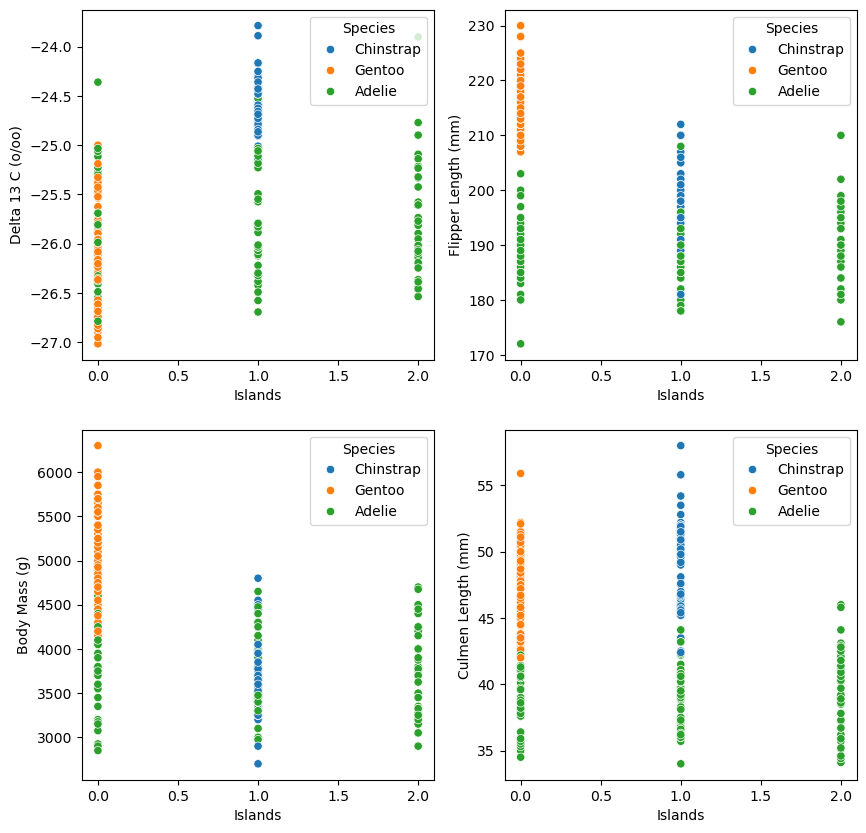

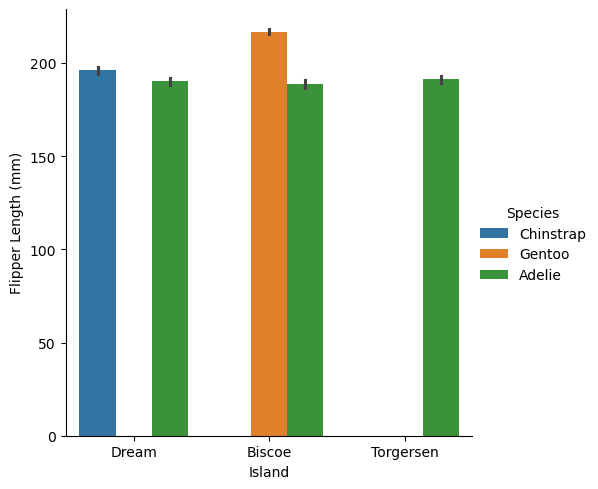

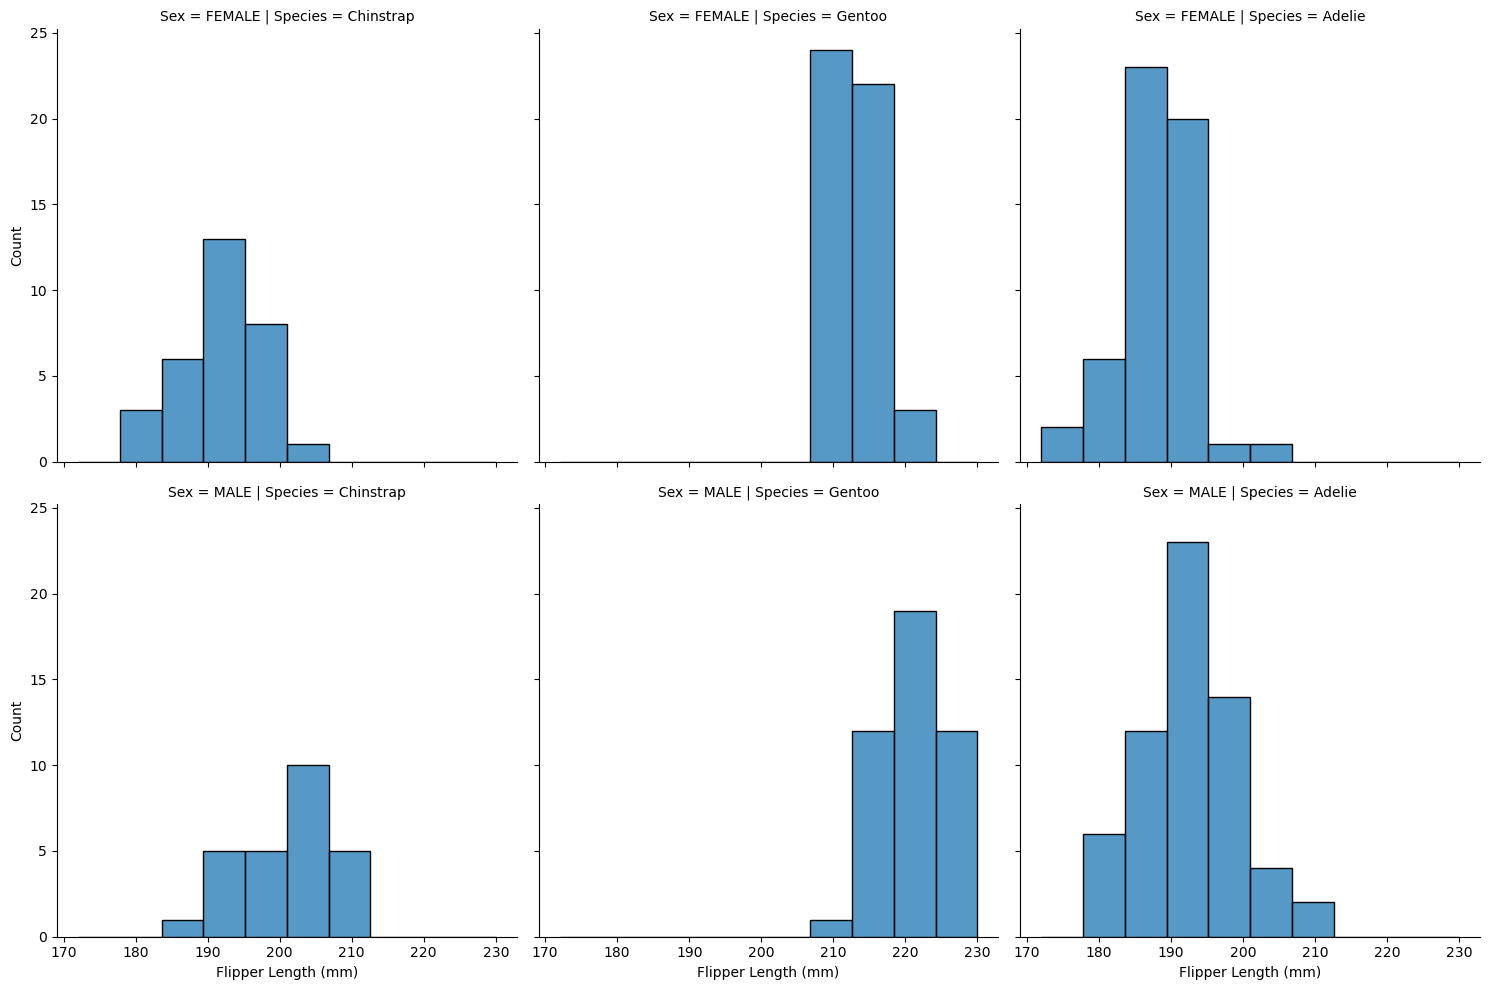

In [163]:
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize = (10, 10))
p1 = sns.scatterplot(d, x = "Islands", y = "Delta 13 C (o/oo)", hue = "Species", ax = ax[0,0])
p2 = sns.scatterplot(d, x = "Islands", y = "Flipper Length (mm)", hue = "Species", ax = ax[0,1])
p3 = sns.scatterplot(d, x = "Islands", y = "Body Mass (g)", hue = "Species", ax = ax[1,0])
p4 = sns.scatterplot(d, x = "Islands", y = "Culmen Length (mm)", hue = "Species", ax = ax[1,1])

p5 = sns.catplot(data=d, kind="bar", x="Island", y="Flipper Length (mm)", hue="Species")
p6 = sns.displot(d, x="Flipper Length (mm)", col="Species", row="Sex")

In [165]:
#Finds the best pairing of variables
best = ([], 0)
from sklearn.exceptions import ConvergenceWarning

for x in columns:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        X_train1 = X_train[x]
        LR = LogisticRegression()
        m = LR.fit(X_train1, y_train)
        score = LR.score(X_train1, y_train)
        if score > best[1]:
            best = (x, score)
        elif score == best[1]:
            print(x, score)
print(best[0], best[1])

['Island_Biscoe', 'Island_Dream', 'Island_Torgersen', 'Culmen Length (mm)', 'Culmen Depth (mm)'] 0.99609375
['Sex_FEMALE', 'Sex_MALE', 'Culmen Length (mm)', 'Culmen Depth (mm)'] 0.99609375


<h5> The code above finds the best pairing of three variables. As there are two best pairing, in the code below we train two different models. One for the variables Culmen Length (mm), Culmen Depth (mm), and Sex. The other for Culmen Length (mm), Culmen Depth (mm), and Islands.

In [149]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
X_test.head()

LR1 = LogisticRegression()
LR2 = LogisticRegression()

cols1 = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE',]
cols2 = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    mf1 = LR1.fit(X_train[cols1], y_train)
    ms1 = LR1.score(X_test[cols1], y_test)
    mf2 = LR2.fit(X_train[cols2], y_train)
    ms2 = LR2.score(X_test[cols2], y_test)

In [150]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

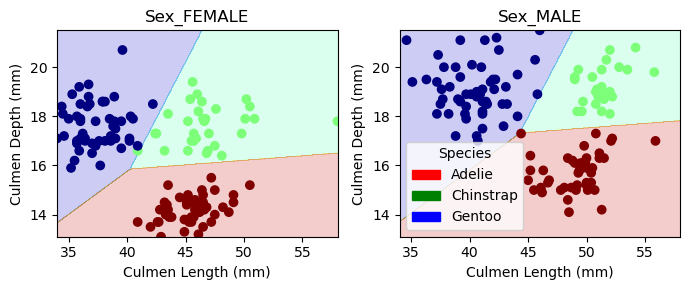

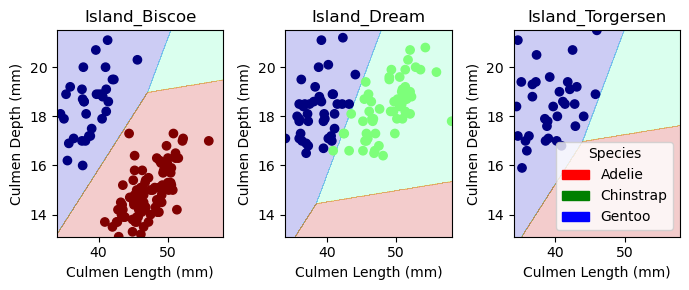

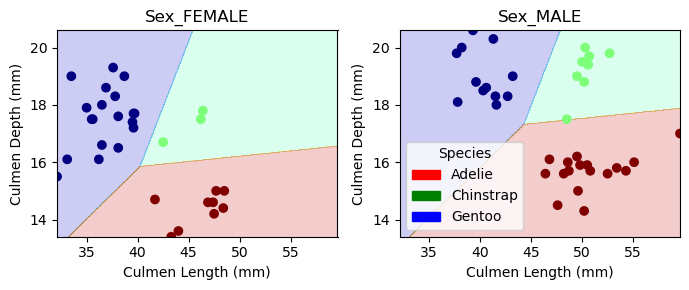

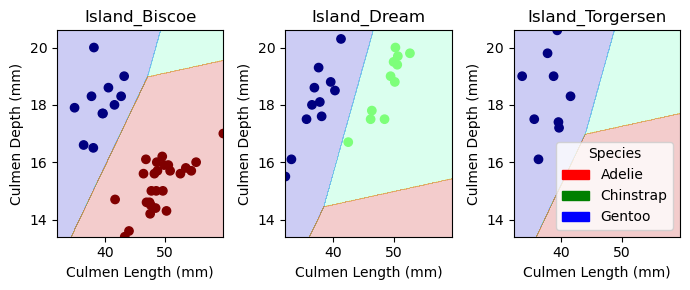

In [151]:
#Plots the decision regions for our two model on the training data
plot_regions(LR1, X_train[cols1], y_train)
plot_regions(LR2, X_train[cols2], y_train)
#Plots the decision regions for our two model on the testing data
plot_regions(LR1, X_test[cols1], y_test)
plot_regions(LR2, X_test[cols2], y_test)

In [171]:
from sklearn.metrics import confusion_matrix

y_test_pred1 = LR1.predict(X_test[cols1])
y_test_pred2 = LR2.predict(X_test[cols2])
C1 = confusion_matrix(y_test, y_test_pred1)
C2 = confusion_matrix(y_test, y_test_pred2)
print(C1, "First Model")
print(C2, "Second Model")

[[31  0  0]
 [ 0 11  0]
 [ 0  0 26]] First Model
[[31  0  0]
 [ 0 11  0]
 [ 0  0 26]] Second Model


<h5> There are no errors in either of the models on the dest data. However, looking at the training and test decision regions I would guess the most common errors come between Adelie and Gentoo predictions.

<h1> Discussion: <h1>

<h5> In this project I have explored a variety of variable combinations and founds two different combinations of three variables that are able to predict penguin species from a test set with a success rate of 100%. With only two variable, depending on which are chosen, it becomes easier to distinguish one of the species but the other two tend to be muddled. However, with the introduction of a third variable the two remaining species become easier to distinguish between. Using the combinations [Culmen Length (mm), Culmen Depth (mm), Sex] and [Culmen Length (mm), Culmen Depth (mm), Islands] we achieve the highest prediction accuracy for penguin species. On the training data we achieve a joint accuracy rate of 99.61% and a success rate of 100% on the test data. 